
# Lab 3: Variance, Correlation, and Covariance in the UBC Weather Station Data

## **Purpose**

In this lab I analyze local (UBC weather station) and global temperature anomaly time-series for the period between 1950-2017. 

In this lab, I utilize linear regression analysis to ask the following three questions regarding the local and global temperature time-series.

1. Is there a trend in the temperature time series?

2. Are the temperature time series correlated with specific internal or external climate forcing (e.g. atmospheric CO2, El Nino oscillation)?

3. Do your results support the claim that there is a global warming trend and that it is caused by increased CO2 concentrations in the atmosphere?

## **My Learning Goals**

- Be able to perform simple linear regression and multiple linear regression analysis in Python.
- Use statistical measures such as coefficients of determination and linear regression coefficients to describe relationships between time-series.
- Evaluate the importance of different factors in explaining the variability of this time-series.
- Assess whether my visualizations allow me to make conclusions about specific hypotheses.

## **Notebook contains**

1. One figure containing the raw time-series of the 7 variables, with linear regression for both temperature time-series (PART 1 & 2)
2. One figure containing histograms of temperature before/after 1985 for local (UBC) and global temperatures (PART 3)
3. One figure containing a scatterplot of the UBC temperature against the global mean temperature (PART 5)
4. The `Lab3_results_spreadsheet` with Table 1 and Table 2 filled with regression results (PART 6 & 7)
5. `table_1.png` and `table_2.png` image contain same results from spreadsheet
6. One figure containing a scatterplot of global mean temperature anomaly against temperature predicted by a multiple linear regression of the 5 forcing variables (PART 8)
7. Analysis questions at the end
 
### **1. The Data**
`lab3_data.xlsx` data file contains time-series data for the following 8 variables:

1. **The date**, formatted as a *decimal year* (decimal year = year + month/12). For example, June 2000 would be “2000.46”.

2. **UBC air temperature anomaly**. This data was recorded at the UBC weather station. The anomaly is relative to the 1961-1990 mean seasonal cycle and is expressed in degrees Celsius.

3. **Global mean air temperature anomaly**. This data was collected by the Climate Research Unit. Anomaly is also relative to the 1961-1990 mean seasonal cycle and is expressed in degrees Celsius.

4. **Total solar irradiance (TSI)**. These values represent the flux of solar energy entering through the top of the atmosphere in W/m<sup>2</sup>. This data comes from the SATIRE project (monthly means) and from Lean et al. (2000) (yearly means), which have been combined to obtain monthly TSI over the 1950-2016 period.

5. **Global mean stratospheric aerosol optical depth (AOD)**. The AOD is a dimensionless value that represents the concentration of aerosols suspended within the atmosphere (particulate matter, smoke, salt, dust etc.). This data was obtained from the Goddard Institute for Space Study. A constant value was assumed for the period 2012-2016 for which no data was available.

6. **Atmospheric CO2 concentration**. This data was obtained from the Earth Policy Institute and is expressed in units of ppm, (parts-per-million).

7. **Anthropogenic SO2 emissions**. This data was obtained from the Pacific Northwest National Laboratory and is expressed in units of Tg/year (Teragrams/year, i.e. 10^9 kilograms/year).

8. **Multivariate ENSO Index (MEI)**. The MEI is a dimensionless variable that is positive during El Niño, and negative during La Niña, phases of the El Niño-Southern Oscillation.

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm

names_arr = ["date", "ubc_temp_anomaly", "global_mean_temp_anomaly", "tsi", "global_mean_AOD", 
         "atmospheric_co2", "antropogenic_so2_emmissions", "mei"]
df = pd.read_excel("/content/lab3_data.xlsx", names = names_arr, index_col = 0)
df.head()

,ubc_temp_anomaly,global_mean_temp_anomaly,tsi,global_mean_AOD,atmospheric_co2,antropogenic_so2_emmissions,mei
date,,,,,,,
1950.041667,NaN,-0.326,1366.136032,0.0034,311.28,31.796755,-1.043
1950.125000,NaN,-0.244,1366.113014,0.0031,311.32,31.985476,-1.162
1950.208333,NaN,-0.178,1366.089845,0.0029,311.36,32.164019,-1.312
1950.291667,NaN,-0.168,1366.066909,0.0029,311.40,32.332745,-1.104
1950.375000,NaN,-0.089,1366.044588,0.0036,311.44,32.492009,-1.433


Next, I plot each time-series as a separate subplot on the same figure to take a low at raw data before doing analysis.

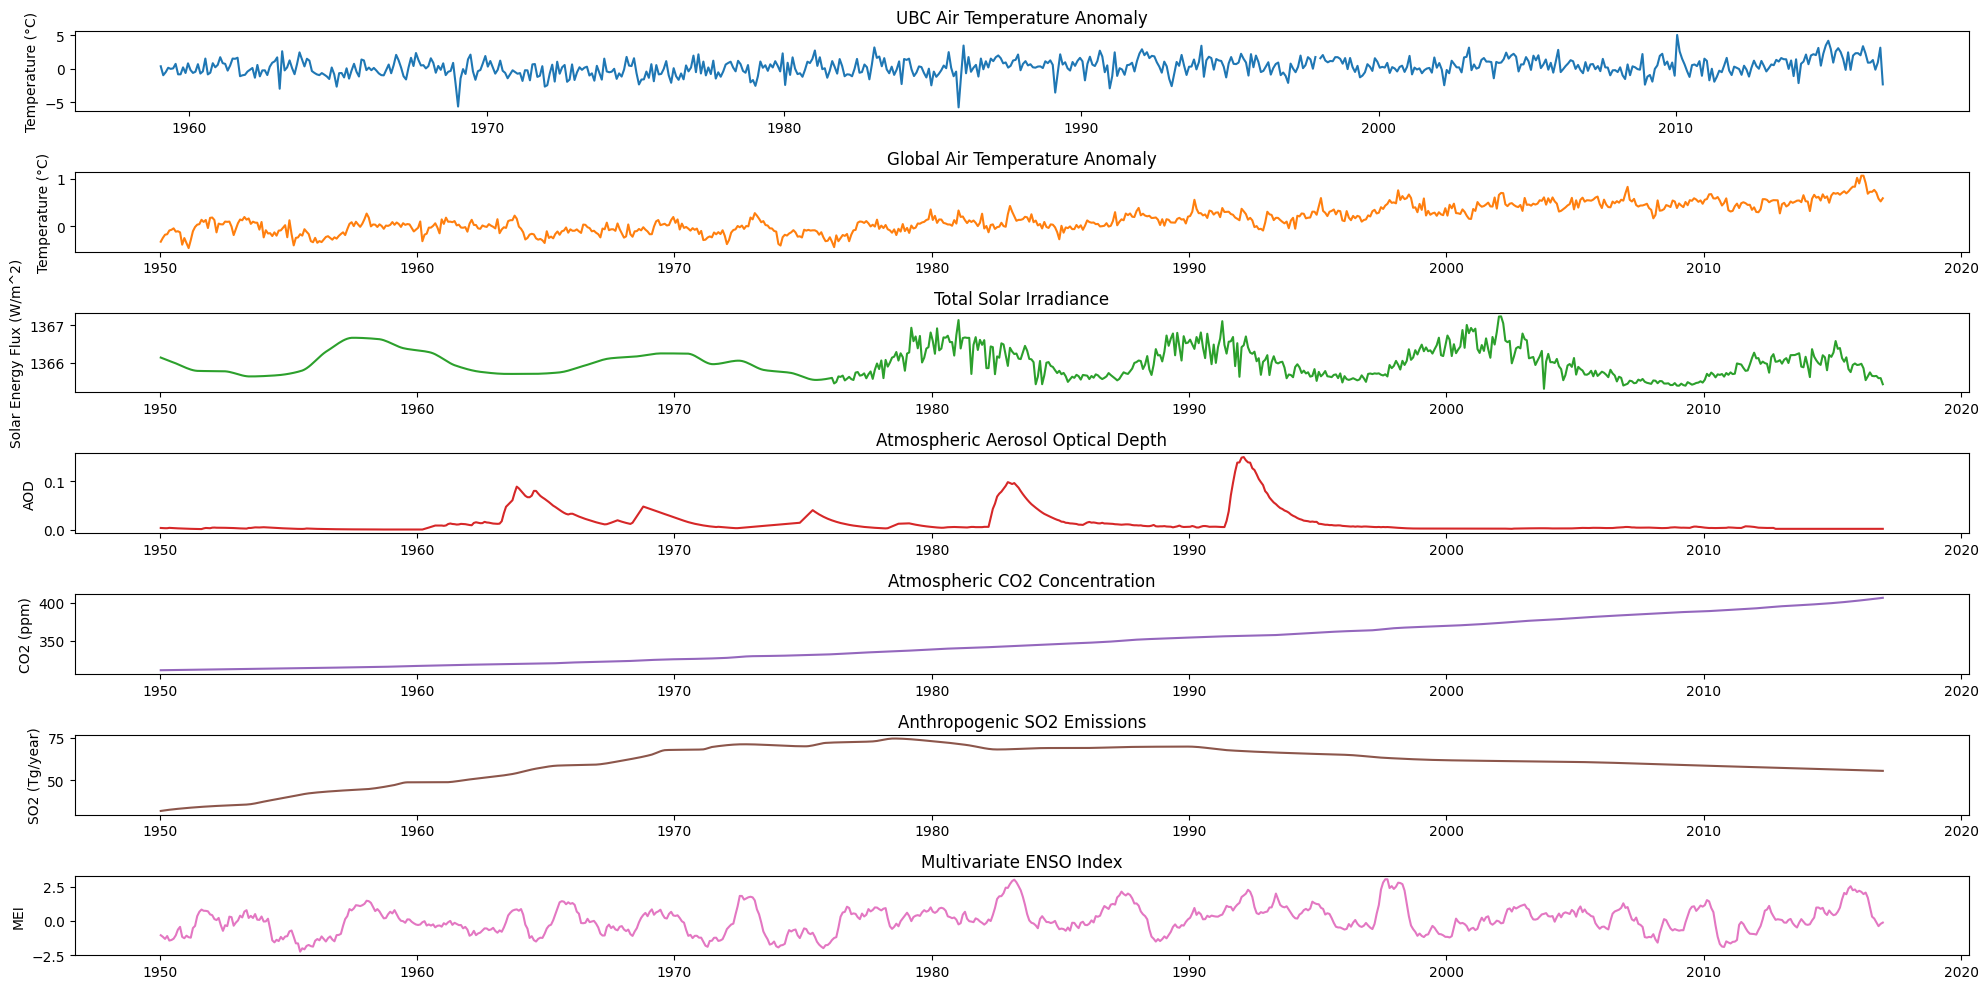

In [3]:
# first, I define a few things that we will used in the plotting loop below, such as a title and color (one for each column of the dataframe)
titles = ['UBC Air Temperature Anomaly','Global Air Temperature Anomaly','Total Solar Irradiance','Atmospheric Aerosol Optical Depth',
          'Atmospheric CO2 Concentration','Anthropogenic SO2 Emissions','Multivariate ENSO Index']
y_labels_arr = ["Temperature (°C)", "Temperature (°C)", "Solar Energy Flux (W/m^2)",
                "AOD", "CO2 (ppm)",
                "SO2 (Tg/year)", "MEI"]
colors = sns.color_palette(None, len(df.columns))

# initialize figure with a figure handle
fig1 = plt.figure(figsize=[20,10])

# loop through each column of the dataframe
for ii in range(1, len(df.columns) + 1):
    # activate the subplot
    current_ax = fig1.add_subplot(7,1,ii)
    # plot the time-series
    current_ax.plot(df.index, df.iloc[:,ii-1], color=colors[ii-1])
    # add figure elements
    current_ax.set_ylabel(y_labels_arr[ii-1])
    current_ax.set_title(titles[ii-1])
    
# get the axes for the subplots, we will use these later
axes = fig1.get_axes()
fig1.tight_layout()


### **2. Linear Regression: Long-term temperature trends**

In this section I perform a simple linear regression on the UBC and global temperature anomaly time-series to evaluate the multi-decadal trend in air temperature anomaly.

To do this I fit a linear regression model that evaluates tempereature anomaly asa function of time. 

- For both the UBC and global temperature anomaly time series. 

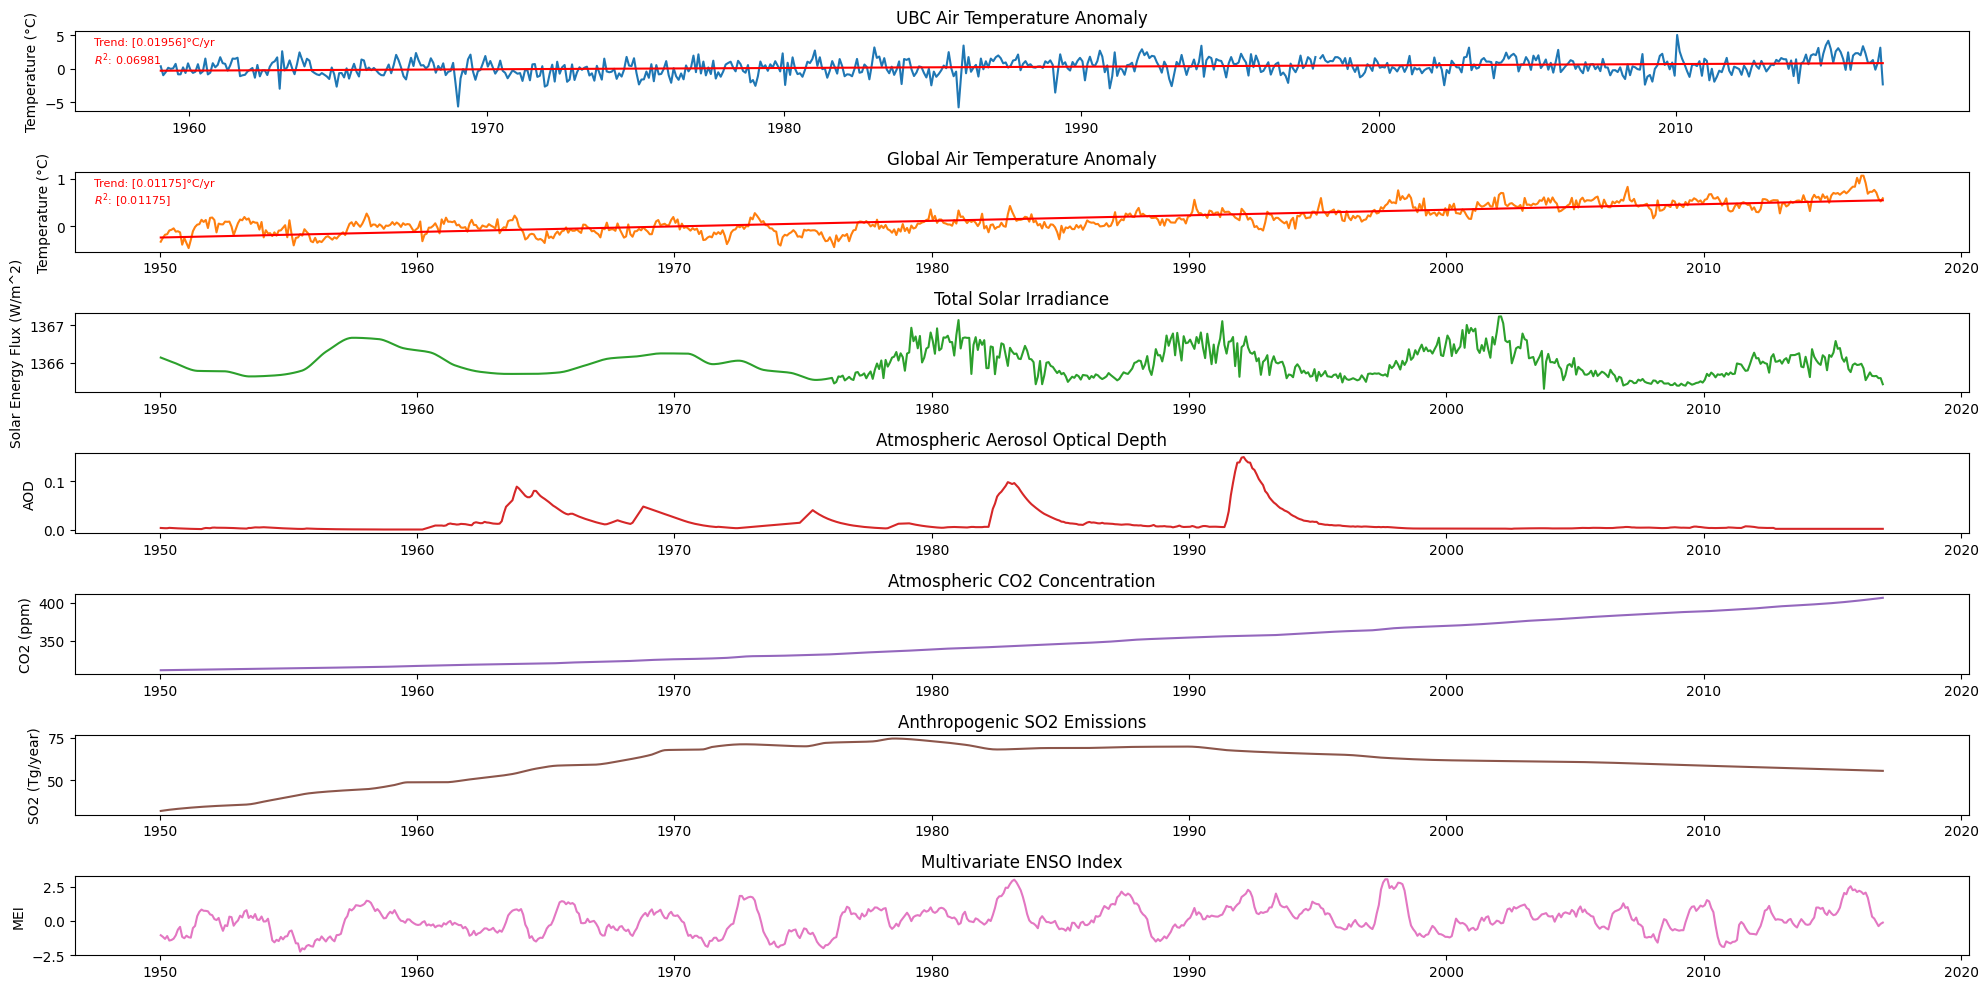

In [4]:
# extract the relevant data into arrays
# ubc temp anomaly
ubc_temp = df['ubc_temp_anomaly'].values
dates = df.index.values

# global temp anomaly 
global_temp = df['global_mean_temp_anomaly']

# mask used to extract nan values out of data 
ubc_ix = ~np.isnan(ubc_temp)
global_ix = ~np.isnan(global_temp)

# use masks to extract temperature and date values
# reshape the data because the LinearRegression function requires 2D arrays as inputs
ubc_temp = ubc_temp[ubc_ix].reshape(-1,1)
ubc_dates = dates[ubc_ix].reshape(-1,1)

# reshaping arrays for global temperature data
global_temp = global_temp[global_ix].to_numpy().reshape(-1,1)
global_dates = dates [global_ix].reshape(-1,1)

# fitting a linear model to the UBC temperature training data
reg_ubc = LinearRegression().fit(ubc_dates, ubc_temp)

# fitting linear model to the global temperature training data
reg_global = LinearRegression().fit(global_dates, global_temp)

# store regression line for ubc data in a variable 
ubc_pred = reg_ubc.predict(ubc_dates)

# store regression line for global temperature in a variable 
global_pred = reg_global.predict(global_dates)

# plot the ubc data regression line
axes[0].plot(ubc_dates, ubc_pred, color='r')
# plot the global data regression line
axes[1].plot (global_dates, global_pred, color='r')

# create a string variable that contains the slope and r2 values to an appropriate number of significant figures
ubc_trend = np.array2string(np.around(reg_ubc.coef_[0], decimals=5))
ubc_r2 = np.array2string(np.around(reg_ubc.score(ubc_dates, ubc_temp), decimals=5))

# global_trend holds slope for global temperature regression as a string
global_trend = np.array2string(np.around(reg_global.coef_[0], decimals=5))
# global_r2 holds r^2 value for global temperature regression as a string
global_r2 = np.array2string(np.around(reg_global.coef_[0], decimals=5))

# annotate the plot with the trend (you will have to determine this - don't forget the units!)
axes[0].annotate('Trend: ' + ubc_trend + '\u00b0C/yr\n$R^2$: ' + ubc_r2, xy=(0.01, 0.60), xycoords='axes fraction', color='r', size=8)
axes[1].annotate('Trend: ' + global_trend + '\u00b0C/yr\n$R^2$: ' + global_r2, xy=(0.01,0.60), xycoords='axes fraction', color='r', size=8)
# # Finally, because we did not initialize the figure in this code cell, we need to call it again to make it display
fig1


### **3. Data Visualization: Histograms**

Here,  I use histograms to visualize the temporal trends in the UBC and global temperature time-series.

code cell below includes:
- One figure, with two subplots: one subplot for the UBC data, and another for the global data.
- In each subplot, two histograms: one of the temperature distribution before 1985, and one of the distribution after 1985.
- For each temperature distribution: a vertical line that represents the mean temperature anomaly value of each distribution.
- In each subplot, an annotation that described the difference between the pre-1985 mean value and the post-1985 mean value.

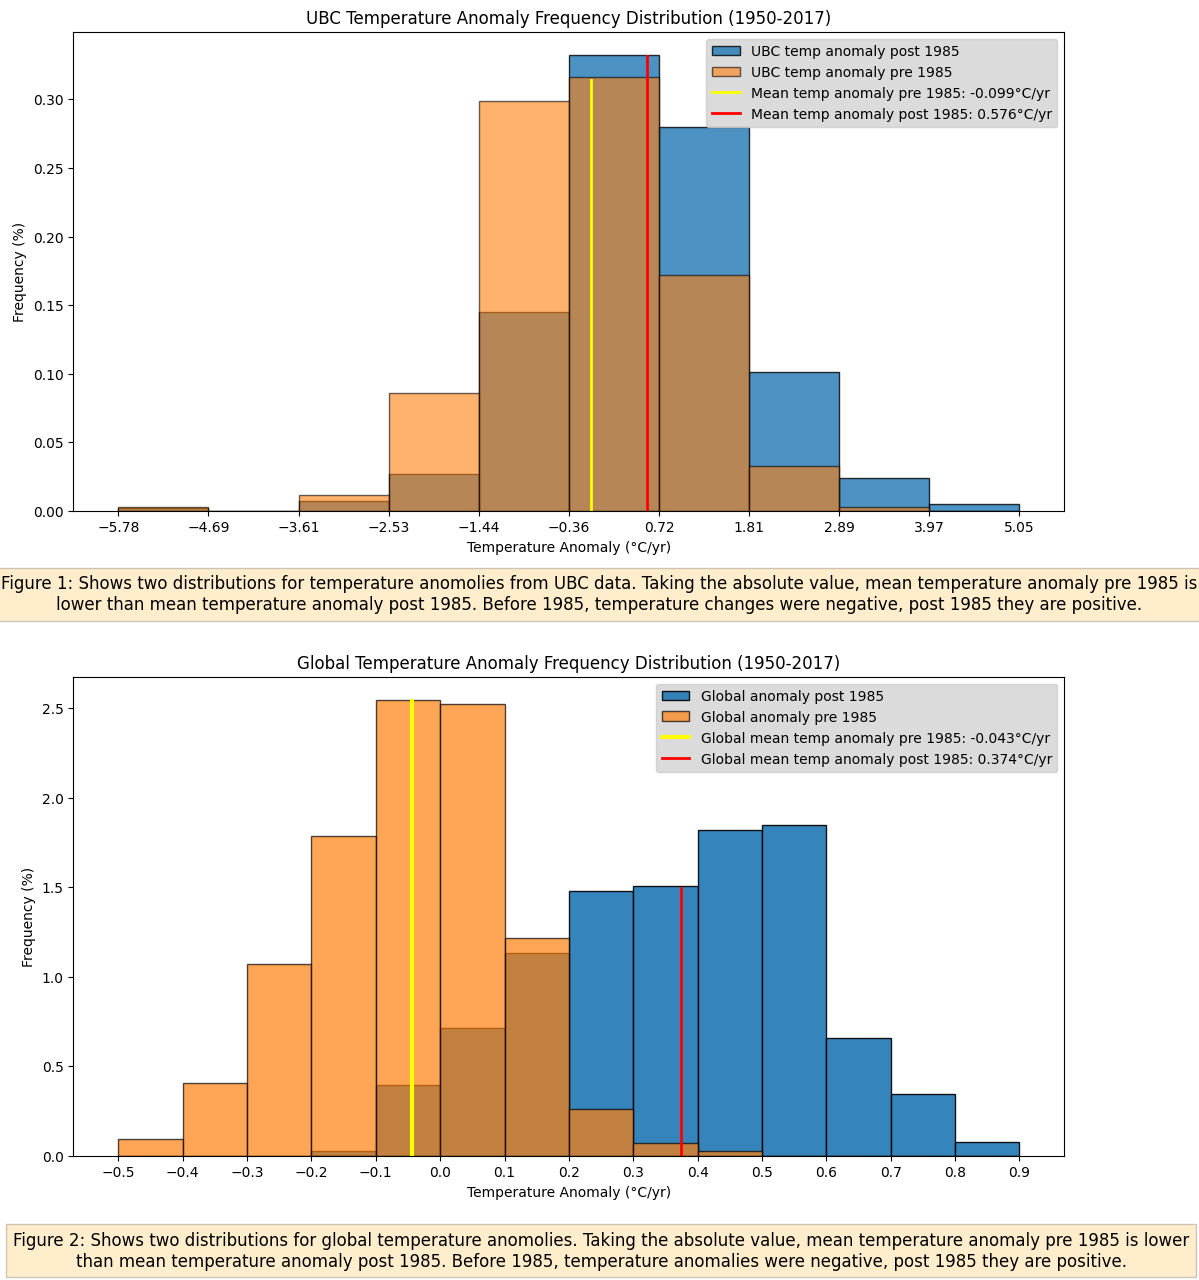

In [5]:
# import case specific
from traitlets.config.application import T
from matplotlib import patches

# one subplot for UBC data and one subplot for global data 
histogram_fig = plt.figure(figsize=[12,12])
ubc_hist = histogram_fig.add_subplot(2,1,1)
global_hist =histogram_fig.add_subplot(2,1,2)

# EROS: dates array
histogram_dates = df.index
# mask for dates below 1985
below_mask = histogram_dates < 1985 
#  mask for dates above 1985
above_mask = histogram_dates > 1985

# EROS: temperatures arrays for UBC data
ubc_temperature_below_1985 = df['ubc_temp_anomaly'][below_mask]
# EROS: mean for ubc_temperature_below_1985
ubc_below_1985_mean = ubc_temperature_below_1985.mean()
ubc_temperature_above_1985 = df['ubc_temp_anomaly'][above_mask]
# EROS: mean of ubc_temperature_above_1985
ubc_above_1985_mean =  ubc_temperature_above_1985.mean()

# EROS: temperature arrays for global data
global_temperature_below_1985 = df['global_mean_temp_anomaly'][below_mask]
# EROS: mean of global_temperature_below)1985
global_below_1985_mean  = global_temperature_below_1985.mean()
global_temperature_above_1985 = df['global_mean_temp_anomaly'][above_mask]
# EROS: mean of global temperature_above_1985
global_above_1985_mean = global_temperature_above_1985.mean()

# EROS: plot UBC data
# for UBC data I use the bins of the data above the year 1985 because it has a greater variability
# These bins are then used to bin the data for temperature below the year 1985
arr, bins, patches = ubc_hist.hist(ubc_temperature_above_1985, label ="UBC temp anomaly post 1985", edgecolor="black", bins="sturges", density=True, alpha=0.8)
ubc_hist.hist(ubc_temperature_below_1985, label="UBC temp anomaly pre 1985",edgecolor="black", density=True, bins=bins, alpha=0.6)

# EROS: set bins for UBC subplot using bins from distribution that includes years above 1985
ubc_hist.set_xticks(bins)

# EROS: label axes for UBC subplot and title
ubc_hist.set_xlabel("Temperature Anomaly (\u00b0C/yr)")
ubc_hist.set_ylabel("Frequency (%)")
ubc_hist.set_title("UBC Temperature Anomaly Frequency Distribution (1950-2017)")

# EROS: plotting the means for ubc temperature data
ubc_hist.axvline(ubc_below_1985_mean, color='yellow',
                 label="Mean temp anomaly pre 1985: " + str(round(ubc_below_1985_mean, ndigits=3)) + "\u00b0C/yr", ymax=0.9, linewidth=2)
ubc_hist.axvline(ubc_above_1985_mean, color='red', label="Mean temp anomaly post 1985: " + str(round(ubc_above_1985_mean, ndigits=3)) + "\u00b0C/yr", ymax=0.949, linewidth=2)

# EROS: figure text for subplot #1
text_ubc = 'Figure 1: Shows two distributions for temperature anomolies from UBC data. '
text_ubc_2 =  'Taking the absolute value, mean temperature anomaly pre 1985 is lower than mean temperature anomaly post 1985. '
text_ubc_3 = 'Before 1985, temperature changes were negative, post 1985 they are positive.'
ubc_hist.text(0, -0.07, text_ubc + text_ubc_2 + text_ubc_3,
            wrap=True, horizontalalignment='center', fontsize=12, fontweight=500, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

# EROS: increasing padding of subplots
histogram_fig.tight_layout(h_pad=5, w_pad=2)
 

# EROS: creating equal bins for global temperature data
bins_global = []
for x in np.arange(-0.5, 1, 0.1):
  bins_global.append(round(x, ndigits=2))
# EROS: set x-ticks for subplot
global_hist.set_xticks(bins_global) 

# EROS: plot global data
arr_02, bins_02, patches_02 = global_hist.hist(global_temperature_above_1985, 
                                               label="Global anomaly post 1985", alpha=0.9, edgecolor="black", bins=bins_global,   
                                               density=True)
arr_03, bins_03, patches_03 = global_hist.hist(global_temperature_below_1985, label ="Global anomaly pre 1985",
                                               alpha=0.7, edgecolor="black", bins=bins_global, density=True)
# EROS: plotting means for global data
global_hist.axvline(global_below_1985_mean, color='yellow',
                 label="Global mean temp anomaly pre 1985: " + str(round(global_below_1985_mean, ndigits=3)) + "\u00b0C/yr", ymax=0.95, linewidth=3)
global_hist.axvline(global_above_1985_mean, color='red', 
                    label="Global mean temp anomaly post 1985: " + str(round(global_above_1985_mean, ndigits=3)) + "\u00b0C/yr", ymax=0.56, linewidth=2)

# EROS: label axes for global subplot and title
global_hist.set_xlabel("Temperature Anomaly (\u00b0C/yr)")
global_hist.set_ylabel("Frequency (%)")
global_hist.set_title("Global Temperature Anomaly Frequency Distribution (1950-2017)")

# EROS: figure text for subplot #2
global_ubc = 'Figure 2: Shows two distributions for global temperature anomolies. '
global_ubc_2 =  'Taking the absolute value, mean temperature anomaly pre 1985 is lower than mean temperature anomaly post 1985. '
global_ubc_3 = 'Before 1985, temperature anomalies were negative, post 1985 they are positive.'
global_hist.text(0.25, -0.6, global_ubc + global_ubc_2 + global_ubc_3,
            wrap=True, horizontalalignment='center', fontsize=12, fontweight=500, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

# display legends
global_hist.legend(facecolor='lightgrey')
ubc_hist.legend(facecolor='lightgrey')

### **4. Decadal Variations in Trends**

Increasing CO2 concentration tends to cause an increase of global mean temperature because of the greenhouse effect. 

However, many other factors impact variations of global mean temperature. 

In particular, at decadal timescales, events such as El Niño or volcanic eruptions can cause fluctuations in temperature that will counteract or enhance the effect of rising CO2. 

To quantify these fluctuations, I will calculate trends in the temperature anomalies time series, but for each decade over the 1950-2016 period. 

For example, for the 1950's and for the global mean temperature anomaly time series, I perform a linear regression of the 1950-1959 temperatures against time and find the slope

In [ ]:
# DECADAL TRENDS VARIATION FOR UBC DATA
# EROS: extract UBC data from df 
ubc_temp_new = df['ubc_temp_anomaly']

dec_ubc_trend = []
dec_ubc_conf = []
dec_ubc_r2 = []

# use for-loop to iterate through the desired decades
for ii, decade in enumerate(range(1950, 2020, 10)):
  # get x and y regression variables 
  x = df[decade:decade+10].index
  y_ubc = df[decade:decade+10]['ubc_temp_anomaly']    
  # add a column of ones to the x variables (required for statsmodel regression)
  x = sm.add_constant(x)    
  # fit linear model to training data (drop missing values)
  ubc_model = sm.OLS(y_ubc, x, missing='drop').fit()
  # store the trend, 95% confidence intervals, and Rsquare for each decade
  dec_ubc_trend.append(ubc_model.params[1])
  dec_ubc_conf.append(ubc_model.conf_int()[1:])
  dec_ubc_r2.append(ubc_model.rsquared)
    
    
# convert decadal regression stats to numpy
dec_ubc_trend = np.around(np.asarray(dec_ubc_trend), decimals=3)
print(dec_ubc_trend)
dec_ubc_conf = np.around(np.asarray(dec_ubc_conf), decimals=3)
print(dec_ubc_conf)
dec_ubc_r2 = np.around(np.asarray(dec_ubc_r2), decimals=3)
print(dec_ubc_r2)

[ 0.261 -0.024  0.059  0.062 -0.001 -0.024  0.245]
[[[-1.178  1.701]]

 [[-0.099  0.051]]

 [[-0.007  0.126]]

 [[-0.019  0.142]]

 [[-0.075  0.074]]

 [[-0.088  0.04 ]]

 [[ 0.099  0.391]]]
[0.016 0.003 0.026 0.019 0.    0.005 0.119]


In [6]:
# EROS: DECADAL TREND FOR GLOBAL DATA

dec_global_trend = []
dec_global_conf = []
dec_global_r2 = []

# use for-loop to iterate through the desired decades
for ii, decade in enumerate(range(1950, 2020, 10)):
  # get x and y regression variables (your index should use the loop variable to select a decade of data)
  x = df[decade:decade+10].index
  y_global = df[decade:decade+10]['global_mean_temp_anomaly']    
  # add a column of ones to the x variables (required for statsmodel regression)
  x = sm.add_constant(x)    
  # fit linear model to training data (drop missing values)
  global_model = sm.OLS(y_global, x, missing='drop').fit()
  # store the trend, 95% confidence intervals, and Rsquare for each decade
  dec_global_trend.append(global_model.params[1])
  dec_global_conf.append(global_model.conf_int()[1:])
  dec_global_r2.append(global_model.rsquared)
    
    
# convert decadal regression stats to numpy
dec_global_trend = np.around(np.asarray(dec_global_trend), decimals=3)
print(dec_global_trend)
dec_global_conf = np.around(np.asarray(dec_global_conf), decimals=3)
print(dec_global_conf)
dec_global_r2 = np.around(np.asarray(dec_global_r2), decimals=3)
print(dec_global_r2)

[ 0.007 -0.006  0.008  0.006  0.021  0.01   0.05 ]
[[[-0.003  0.017]]

 [[-0.014  0.002]]

 [[-0.001  0.017]]

 [[-0.001  0.013]]

 [[ 0.012  0.03 ]]

 [[ 0.003  0.017]]

 [[ 0.036  0.064]]]
[0.016 0.02  0.027 0.023 0.15  0.058 0.38 ]



**In the code cell below:** I perform a linear regression on the full UBC and global temperature anomaly time-series. 


In [ ]:
# LINEAR REGRESSION ON FULL UBC TEMPERATURE
full_ubc_trend = []
full_ubc_conf = []
full_ubc_r2 = []

# get x and y regression variables 
full_ubc_x = df.index
full_y_global = df['ubc_temp_anomaly']    
# add a column of ones to the x variables (required for statsmodel regression)
full_ubc_x = sm.add_constant(full_ubc_x)    
# fit linear model to training data (drop missing values)
full_ubc_model = sm.OLS(full_y_global, full_ubc_x, missing='drop').fit()
# store the trend, 95% confidence intervals, and Rsquare for each decade
full_ubc_trend.append(full_ubc_model.params[1])
full_ubc_conf = full_ubc_model.conf_int()[1:]
full_ubc_r2.append(full_ubc_model.rsquared)
    
    
# convert decadal regression stats to numpy
full_ubc_trend = np.around(np.asarray(full_ubc_trend), decimals=3)
print(full_ubc_trend)
full_ubc_conf = np.around(np.asarray(full_ubc_conf), decimals=3)
print(full_ubc_conf)
full_ubc_r2 = np.around(np.asarray(full_ubc_r2), decimals=3)
print(full_ubc_r2)

[0.02]
[[0.014 0.025]]
[0.07]


In [ ]:
# LINEAR REGRESSION ON FULL UBC AND GLOBAL TEMPERATURE 
full_global_trend = []
full_global_conf = []
full_global_r2 = []

# get x and y regression variables 
full_global_x = df.index
full_y_global = df['global_mean_temp_anomaly']    
# add a column of ones to the x variables (required for statsmodel regression)
full_global_x = sm.add_constant(full_global_x)    
# fit linear model to training data (drop missing values)
full_global_model = sm.OLS(full_y_global, full_global_x, missing='drop').fit()
# store the trend, 95% confidence intervals, and Rsquare for each decade
full_global_trend.append(full_global_model.params[1])
full_global_conf = full_global_model.conf_int()[1:]
full_global_r2.append(full_global_model.rsquared)
    
    
# convert decadal regression stats to numpy
full_global_trend = np.around(np.asarray(full_global_trend), decimals=3)
print(full_global_trend)
full_global_conf = np.around(np.asarray(full_global_conf), decimals=3)
print(full_global_conf)
full_global_r2 = np.around(np.asarray(full_global_r2), decimals=3)
print(full_global_r2)

[0.012]
[[0.011 0.012]]
[0.671]


### **Table 1 image** in this folder summarize the analysis above. 

It includes the coefficient of determination for each decadal analysis.

And also the coefficient of determination for the full UBC and global temperature anomaly time-series. 

Additionally, the highlighted decades indicate where the is positive within the 95% confidence interval.

### **5. Correlation Between Local and Global Climate**

Previous sections highlight differences between trends in the temperature time-series measured at UBC and the global mean temperature. 

To further characterize these differences, I plot the UBC temperature anomaly vs the global mean temperature anomaly 

The plot includes the Pearson correlation coefficient of the two time-series as well as the associated p-value. 

Text(0.5, 1.0, 'UBC Mean Temperature vs Global Mean Temperature Anomaly (1950-2017)')

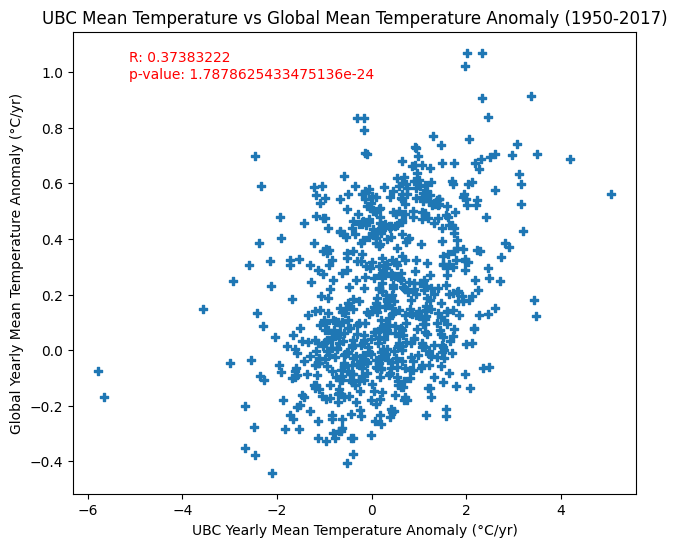

In [ ]:
# EROS: create figure object
fig1 = plt.figure(figsize=[16, 6])

# EROS: get data for plot
ubc_temp_new = df['ubc_temp_anomaly'].values
global_temp_new = df['global_mean_temp_anomaly']

# EROSl extract only the non-nan non-inf values from the variables
ubc_ix_new = ~np.isnan(ubc_temp_new)

# EROS: plot ubc temperature anomaly
ax1 = fig1.add_subplot(1,2, 1)
ax1.scatter(ubc_temp_new[ubc_ix_new], global_temp_new[ubc_ix_new], marker="P")

# EROS: get p-value and correlation coefficient for plot
corr_data = stat.pearsonr(ubc_temp_new[ubc_ix_new], global_temp_new[ubc_ix_new])

# EROS: annotate figure with correlation statistics
ax1.annotate('R: ' + str(np.round(corr_data[0], decimals=8)) + '\np-value: ' + str(corr_data[1]),
             xy=(0.1, 0.90),
             xycoords='axes fraction', color='r')

# EROS: labels and titles
ax1.set_xlabel("UBC Yearly Mean Temperature Anomaly (\u00b0C/yr)")
ax1.set_ylabel("Global Yearly Mean Temperature Anomaly (\u00b0C/yr)")
ax1.set_title("UBC Mean Temperature vs Global Mean Temperature Anomaly (1950-2017)")

### **6. Correlating Global Temperature with Climate Forcing**

For each of the 5 climate forcing variables (TSI, AOD, CO2, SO2 and MEI):
- I perform a simple linear regression of the global mean temperature anomaly against the considered variable - i.e. the global temperature anomaly is the dependent variable.
- then report the slope of the linear regression the 95% confidence interval of the slope, and the coefficient of determination in **Table 2 image** 

In [ ]:
# GLOBAL MEAN TEMPERATURE ANOMALY
global_mean_temperature = df['global_mean_temp_anomaly'] 

# TSI fit linear model 
x_tsi = sm.add_constant(df['tsi'])
tsi_model = sm.OLS(global_mean_temperature, x_tsi, missing='drop').fit()
# print(tsi_model.params)
# print(tsi_model.conf_int())
# print(tsi_model.rsquared)

# AOD fit linear model (Atmospheric Aerosol Optical Depth)
x_aod = sm.add_constant(df['global_mean_AOD'])
aod_model = sm.OLS(global_mean_temperature, x_aod, missing='drop').fit()
# print(aod_model.params)
# print(aod_model.conf_int())
# print(aod_model.rsquared)


# atmospheric_co2 concentration linear regression
x_CO2 = sm.add_constant(df['atmospheric_co2'])
CO2_model = sm.OLS(global_mean_temperature, x_CO2, missing='drop').fit()
print(CO2_model.params)
# print(CO2_model.conf_int())
# print(CO2_model.rsquared)


# MEI linear regression ('Multivariate ENSO Index)
x_mei = sm.add_constant(df['mei'])
mei_model = sm.OLS(global_mean_temperature, x_mei, missing='drop').fit()
# print(mei_model.params)
# print(mei_model.conf_int())
# print(mei_model.rsquared)

# SO2 linear regression (antropogenic_so2_emmissions)
x_so2 = sm.add_constant(df['antropogenic_so2_emmissions'])
mei_model = sm.OLS(global_mean_temperature, x_so2, missing='drop').fit()
# print(mei_model.params)
# print(mei_model.conf_int())
# print(mei_model.rsquared)


const             -2.835959
atmospheric_co2    0.008603
dtype: float64


### **7. Combined impacts of multiple forcing on global temperature anomaly**

#### Multiple Regression Analysis

**code cell below:** 

Includes a multiple linear regression on both the UBC and global temperature anomaly time-series, using all of the climate forcing time-series (TSI, AOD, CO2, SO2 and MEI) as independent regression variables.

The regression coefficients and 95% confidence intervals associated with each independent variable are reported in **Table 2 Image**

In [ ]:
# MULTIPLE LINEAR REGRESSION on Global Temperature Data

# EROS: extract independent variables for multiple linear regression
independent_variables = df[['tsi', 'global_mean_AOD', 'atmospheric_co2', "antropogenic_so2_emmissions", "mei" ]]

# EROS: add a column of ones to the x variables (required for statsmodel regression)
independent_variables = sm.add_constant(independent_variables)  

# EROS: fit linear model to training data (drop missing values)
multiple_reg_model = sm.OLS(df['global_mean_temp_anomaly'], independent_variables, missing='drop').fit()
print(multiple_reg_model.params)
print(multiple_reg_model.conf_int())
print(multiple_reg_model.rsquared)
multiple_reg_model.summary()


const                         -76.732477
tsi                             0.054365
global_mean_AOD                -1.229967
atmospheric_co2                 0.008482
antropogenic_so2_emmissions    -0.005193
mei                             0.075324
dtype: float64
                                      0          1
const                       -105.957407 -47.507548
tsi                            0.032979   0.075751
global_mean_AOD               -1.592743  -0.867191
atmospheric_co2                0.008168   0.008797
antropogenic_so2_emmissions   -0.006004  -0.004383
mei                            0.066846   0.083801
0.8381818288126062


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     global_mean_temp_anomaly   R-squared:                       0.838
Model:                                  OLS   Adj. R-squared:                  0.837
Method:                       Least Squares   F-statistic:                     826.7
Date:                      Fri, 31 Mar 2023   Prob (F-statistic):          1.17e-312
Time:                              18:23:29   Log-Likelihood:                 622.52
No. Observations:                       804   AIC:                            -1233.
Df Residuals:                           798   BIC:                            -1205.
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -76.7325     14.888     -5.154      0.000    -105.957     -47.508
tsi                             0.0544      0.011      4.990      0.000       0.033       0.076
global_mean_AOD                -1.2300      0.185     -6.655      0.000      -1.593      -0.867
atmospheric_co2                 0.0085      0.000     52.966      0.000       0.008       0.009
antropogenic_so2_emmissions    -0.0052      0.000    -12.580      0.000      -0.006      -0.004
mei                             0.0753      0.004     17.441      0.000       0.067       0.084
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.663
Skew:                           0.070   Prob(JB):                        0.435
Kurtosis:                       3.173   Cond. No.                     5.32e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **8. Evaluating the Performance of the Multiple Linear Regression Model**

Evaluating performance of  linear model by comparing the predicted temperature anomalies to the observed temperature anomalies. 

Code below includesL 

1. One scatterplot that contains the MLR-predicted global temperature anomalies vs. the observed global temperature anomalies.
3. A 1-to-1 line on the scatterplot - i.e. a line that describes y = x (all datapoints would be on this line if the regression was perfect in predicting the temperature anomaly).
2. An annotation on the figure that describes the measures of model error - the Mean Absolute Error (MAE), the Mean Square Error (MSE), and the Root Mean Squared Error (RMSE).


Text(0.25, -1.2, "Mean absolute error (MAE): 0.089 °C/yr, Mean squared error (MSE): 0.012 $°C^2$/$yr^2$, Root mean squared error (RMSE): 0.112 °C/yr. MEA suggests actual and predicted values differ by 0.089 (°C/yr) units. With an MSE of 0.012 °$C^2$/$y^2$, the model's predictions are deemed accurate as the low value suggests a strong fit between the predicted and actual values. Similarly the low RMSE value of 0.112 (°C/yr)  indicates that the model's predicted values are generally close to the actual values, with minimal deviation.")

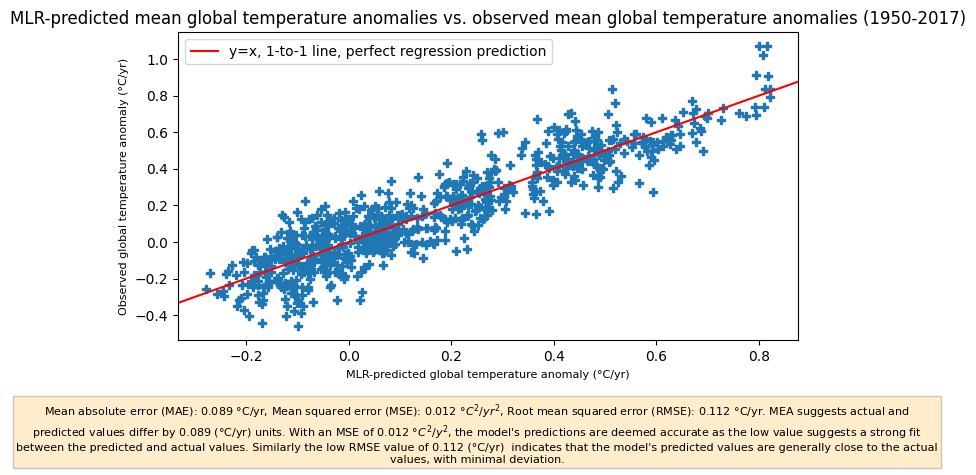

In [ ]:
# EROS: create figure object and axes object for plot
mlr_fig, mlr_ax = plt.subplots(figsize=[8, 4])

# these are the independent or 'predictor' variables of our linear model (Forcings for global temperature)
Forcing1 = df['tsi'] 
Forcing2 = df['global_mean_AOD']
Forcing3 = df['atmospheric_co2'] 
Forcing4 = df['antropogenic_so2_emmissions']
Forcing5 = df['mei'] 

# EROS: combine forcing variables into an array where each column is a forcing
independent_variables = np.stack((Forcing1, Forcing2, Forcing3, Forcing4, Forcing5), axis=1)
reg = LinearRegression().fit(independent_variables, df['global_mean_temp_anomaly'])

# EROS: predict values based on regression model
predicted_values = reg.predict(independent_variables)
# EROS: plot predicted values vs observed values
plt.scatter(predicted_values, df['global_mean_temp_anomaly'], marker="P")


# EROS: add titles and labels to graph
mlr_ax.set_title("MLR-predicted mean global temperature anomalies vs. observed mean global temperature anomalies (1950-2017)")
mlr_ax.set_xlabel("MLR-predicted global temperature anomaly (\u00b0C/yr)", size=8)
mlr_ax.set_ylabel("Observed global temperature anomaly (\u00b0C/yr)", size=8)
mlr_ax.axline((0, 0), slope=1, color='red', label="y=x, 1-to-1 line, perfect regression prediction")

# EROS: legend
mlr_ax.legend()

# Measures of model error:

# Mean Absolute Error
mean_absolute_error = str(sm.tools.eval_measures.meanabs(predicted_values, df['global_mean_temp_anomaly']))
# Mean Square Error
mean_square_error = str(sm.tools.eval_measures.mse(predicted_values, df['global_mean_temp_anomaly']))
# Root Mean Squared Error
root_mean_squared_error = str(sm.tools.eval_measures.rmse(predicted_values, df['global_mean_temp_anomaly']))

mlr_fig_text = "Mean absolute error (MAE): 0.089 \u00b0C/yr, Mean squared error (MSE): 0.012 $\u00b0C^2$/$yr^2$, Root mean squared error (RMSE): 0.112 \u00b0C/yr. "

mae_description = "MEA suggests actual and predicted values differ by 0.089 (\u00b0C/yr) units."
msqe_description = " With an MSE of 0.012 \u00b0$C^2$/$y^2$, the model's predictions are deemed accurate as the low value suggests a strong fit between the predicted and actual values."
root_mean_squared_description = " Similarly the low RMSE value of 0.112 (\u00b0C/yr)  indicates that the model's predicted values are generally close to the actual values, with minimal deviation."
# EROS: figure text
mlr_ax.text(0.25, 
            -1.2,
            mlr_fig_text + mae_description + msqe_description + root_mean_squared_description,
            wrap=True, 
            horizontalalignment='center', fontsize=8, fontweight=500, bbox={"facecolor":"orange", "alpha":0.2, "pad":2})


### **9. Interpretation of Results**

### Temperature Trends: 

Using the time-series that you plotted in Part 1 and the regression analysis that you performed in Part 2 and Part 4 (results found in Table 1), answer the following:

1.	**Describe and compare the variability in the local and global temperature anomaly time-series. Is one more variable than the other? Do they have similar variability patterns – e.g. periodic fluctuations, long-term trends etc.?**

- Local temperature anomalies are more variable than global temperature anomalies. This can be seen in the histograms that show temperature anomalies for UBC temperature and for global temperature. Temperature anomalies for UBC range from -5.78 degrees Celsius/year to 5.05 degrees Celsius/year. Whereas global temperature anomalies range from -0.5 degrees Celsius/year to 0.9 degrees Celsius/year. Additionally, in the decadal regressions from Part 4, it is observed that for UBC, the trend is positive in some decades and negative in other decades. The global trend shows more consistency, with only one decade having a negative trend. 


2.	**Do you think the term ‘global warming’ is appropriate to describe the time-series that you have plotted? Why, or why not?**

- Global warming is appropriate as the time-series shows that both the trend for local and global anomalies are positive and significant according to the results from Part 4. UBC trend 0.020 degrees Celsius/per year and global trend 0.012 degrees Celsius/per year. 


3.	**What might explain the similarities and differences between the local and global temperature anomaly time-series?**

- The similarities and differences between local and global temperature anomaly time-series could be due to various factors such as geographical location, human activity, measurement methods, and natural variability. Local factors such as elevation, proximity to the coast, and mountain ranges can influence local temperatures, making them differ to global temperatures. Areas with high urbanization can also influence trends of local temperatures. Urban areas have higher temperatures, and this may be there is a higher trend for local temperature changes compared to global anomalies. Moreover, different collection methods can lead to discrepancies as well. Local data is from one station only whereas global data is probably the average of many stations. Finally, natural variability in weather patterns can affect regions differently leading to differences in temperature anomaly trends. 

4.	**If the trend that you calculated for the global temperature anomaly time-series were to remain constant for the next 100 years, how many degrees of warming would we observe?**

- We would observe 1.2 degrees of warming. 

5.	**Given the results of your decadal regression analysis, do you think it is reasonable to assume that the warming trend that you calculated will remain constant for the next 100 years?**

- It is not reasonable to assume that the warming trend will remain constant. At the global level, for the decadal analysis, every decade the warming trend has changed. In recent decades, from 1990 onwards, the warming trend appears more variable than in decades before 1990. In 2000, the warming trend went from 0.021 to 0.010 and then in 2010 in jumped back up to 0.050. Nonetheless, from 1950 to 1990 the trend changed slightly. Now, for the local trend, there is even more variability in decadal trends. Some decades show negative trend, some show positive trend. This variations in warming trends suggest that the current warming trend will not remain constant for the next 100 years. 



### Climate Forcing Regression Analysis: 

1.	**Given the results of your simple linear regression, which forcing variables (if any) are most strongly correlated to the global temperature anomaly? Which forcing variables (if any) are most weakly correlated?**

- The variables that are most strongly correlated to global temperature anomaly are Atmospheric CO2 concentrations (R2 = 0.73 )and Multivariate Enso Index (R2=0.16). Variables that are most weakly correlated are Total Solar Irradiance (R2 =0.0002) and Anthropogenic SO2 emissions (R2 = 0.0063).

2.	**For each forcing variable, briefly explain if the relationship between the forcing variable (correlation sign and strength) matches your expectation.** 

-	TSI: Positive relationship with global temperature anomaly but weak correlation. Matches my expectations as total solar irradiance does not appear to have increased linearly since 1950. 
-	AOD: Negative relationship with global temperature anomaly and weak correlation. I thought that more aerosol particles in the air would lead to a warming effect but it appears they have a cooling effect. This shows that aerosol particles reflect incoming radiation and do not absorb as much of the outgoing radiation.
-	CO2: Positive relationship and strongly correlated. This matches my expectations as it is well known within the scientific literature that atmospheric CO2 is one of the greatest drivers of global warming. 
-	SO2: Positive relationship and weakly correlated. I expected that it would have a positive relationship but not too much impact as other green house gases such as CO2. 
-	MEI: Positive relationship and moderate correlation. It makes sense for this variable to have a moderate correlation since natural climate variability can lead to temperature fluctuations. However, it is hard to know whether this fluctuations would be a decrease or increase in warming trends.  

3.	**In terms of the individual forcing variables, are the results of the simple linear and multiple linear regression always compatible? Is the direction (positive/negative) and strength of the correlation the same in the MLR and SLR for each forcing variable?**

- Results of simple linear and multiple linear regression are not always compatible. For some variables, the direction is positive for simple regression and negative for multiple regression (for SO2 specifically). In terms of strength, the MLR provides a more accurate prediction. 

4.	**Which method do you think most accurately describes the dependence of global temperature on each forcing?**

- MLR most accurately describes the dependence of global temperature on each forcing because in nature, these variables do not exist on their own. It would be too idealistic to only consider the effect of one variable on global temperature. 



### Using Linear Regression to Predict Future Temperature Under Various Emission Scenarios:

In its AR5 report (2014), the International Panel on Climate Change (IPCC) used various greenhouse gas emission scenarios to forecast future temperatures. For three of these scenarios, the atmospheric CO2 in 2100 was assumed to be 400, 500 and 950 ppm, respectively. Using a predictive model, they found that these concentrations would correspond to temperature anomalies of 1±0.4, 1.8±0.5 and 3.7±0.7 °C, respectively, relative to the 1986-2005 global mean temperature. 

1.	**Please calculate the predicted temperature according to your SLR model at CO2 concentrations of 400, 500, and 950 ppm. You do not need to use Python to do this, you only need to review your findings in Table 2 and to know that the y-intercept for the relevant regression equation is XX °C.**

- At 400 ppm: y = 0.0086030x – 2.835959, y = 0.605541 Celsius
- At 500 ppm: y = 0.0086030 * (500 ppm) – 2.835959, y = 1.465541 Celsius
- At 600 ppm: y = 0.0086030 * (600 ppm) – 2.835959, y = 2.3258 Celsius

2.	Are the results of your simple linear regression analysis compatible with the results of the IPCC model? 

- Yes, they are compatible with the results of the IPCC model. At 400 ppm IPCC predicts a range of 0.6 – 1.4 degrees, my prediction at 400ppm falls within that interval. Similar results occur for the temperatures anomalies my model predicts at 500ppm and 600ppm, the prediction always sitting within the range provided by the IPCC. 

3.	What assumption(s) have you made about other climate forcings by choosing to use the SLR to predict the future temperature? 
- The assumption I have made by using SLR is that other climate forcings do not have an impact on temperature anomalies in parallel with the studied variable. Thus, when I predict temperature anomalies based on CO2 atmospheric concentrations, I assume that other forcings do not have an effect on the predicted temperature anomaly. 

4.	Discuss where disagreement between your findings and the results of the IPCC model (if any) may come from. 
- My model and the model of the IPCC suggest similar results.


### Limitations of Linear Regression: 

1.	Briefly summarize the limitations of an approach based on linear regression to establish causality between two time-series and make predictions such as you did in the previous section. 

-	Assumption of linearity: assuming there is a linear relationship between dependent and independent variable
-	Underfitting: model used for prediction might be too simple and does not capture complexity of data
-	Multicollinearity: happens when two or more independent variables are highly correlated with each other. Makes it difficult to pinpoint the individual contribution of each independent variable to the dependent variable

### Implications of Results: 

Examination of results to see whether they support a handful of statements that have been taken from both scientific and popular sources. 

For each of the following statements, please begin by indicating whether your results: 

- Support the statement 
- Do not support the statement 
- Do not allow you to comment on the statement 

Choose only one option. Briefly explain your choice and indicate whether it applies to the entire statement or only part of it. 

**Statement 1: “Warming of the climate system is unequivocal, and since the 1950s, many of the 
observed changes are unprecedented over decades to millennia.” (IPCC AR5)**

-	Supports the first part of the statement but not the millennia part. My analysis does not include data from a millennium only from the 1950s. Yet from the 1950’s my analysis does show an increase in warming trends.

**Statement 2: “[the main problem for climate scientists is] the fact that there has now been no 
“global warming” for 18 years and six months.” (Breitbart, 2015)**

-	Does not support the statement. My analysis shows that for 50 years there has been an increase in temperature anomalies. If you cherry pick data, certain decades might show a decrease in warming trend but overall the trend increases. 

**Statement 3: “[greenhouse gases] are extremely likely to have been the dominant cause of the 
observed warming since the mid-20th century.” (IPCC AR5)**

-	Supports the statement. My analysis shows that CO2 has a positive effect on global temperature anomalies; however, it does not support the part where it says all greenhouse gases. My analysis shows that SO2 has a negative effect on global temperature anomalies. 

**Statement 4: “We have NOT HAD A MAJOR VOLCANIC ERUPTION for many years and this is the reason of the very sharp increase in global temperatures we are seeing… SO2 [from volcanoes] is the ‘cure’ to put a band-aid on it until it rises again. We are not getting the SO2 needed.” (southerncaliforniaweatherforce.com) [The author here is claiming that the warming signal that we observe is due to a lack of SO2 caused by reduced volcanic emissions. Their claim is that increased SO2 concentrations will ameliorate global warming.]** 

-	Supports statement. My analysis shows that SO2 has negative impact on global temperature anomalies. This means that increases in SO2 probably produce a cooling effect. 

** Statement 5: “In recent decades, changes in climate have caused impacts on natural and 
human systems on all continents and across the oceans.” (IPCC AR5)** 

-	Do not allow me to comment on statement. My analysis does not investigate the impacts of climate change on natural and human systems. 
